# Load the data

In [1]:
import numpy as np
data = np.loadtxt("outputs.csv", delimiter=",")
np.random.shuffle(data)
N = int(len(data) * 0.8)
train_set = data[:N]
test_set = data[N:]

In [2]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

def euler_to_mat(angles):
    x_rad, y_rad, z_rad = angles
    rot_z = np.identity(3)
    rot_z[0,0] = np.cos(z_rad)
    rot_z[0,1] = -np.sin(z_rad)
    rot_z[1,0] = np.sin(z_rad)
    rot_z[1,1] = np.cos(z_rad)

    rot_x = np.identity(3)

    rot_x[1,1] = np.cos(x_rad)
    rot_x[1,2] = -np.sin(x_rad)
    rot_x[2,1] = np.sin(x_rad)
    rot_x[2,2] = np.cos(x_rad)

    rot_y = np.identity(3)

    rot_y[0,0] = np.cos(y_rad)
    rot_y[0,2] = np.sin(y_rad)
    rot_y[2,0] = -np.sin(y_rad)
    rot_y[2,2] = np.cos(y_rad)
    return rot_y @ rot_x @ rot_z

In [3]:
def get_positions(euler_angles, t_m, train=True) -> np.ndarray:
    local_data = train_set.copy() if train else test_set.copy()
    
    pixel_positions = local_data[:,:3]
    translations = local_data[:,3:6]
    rotations = local_data[:,6:]

    # intrinsic transform
    Q_m = euler_to_mat(euler_angles)
    world_positions = (pixel_positions + t_m) @ Q_m.T
    # camera rotation
    for i in range(len(pixel_positions)):
        Q_t = quaternion_rotation_matrix(rotations[i])
        world_positions[i] = world_positions[i] @ Q_t.T
    
    # camera translation
    return world_positions + translations
def objective(x, train=True):
    positions = get_positions(x[:3], x[3:], train)
    average = np.average(positions, axis=0)
    displacements = positions - average
    return np.sum(displacements**2)/len(displacements)

In [4]:
import scipy.optimize

In [5]:
x0 = [0, np.pi/2, -np.pi/2, 0.,0.,0.]
ret = scipy.optimize.minimize(objective, x0)

In [6]:
import matplotlib.pyplot as plt
def plot_positions(thetas, translations, train=True):
    positions = get_positions(thetas, translations, train).T
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(positions[0], positions[1], positions[2])
    return fig, ax

Text(0.5, 0.98, 'Optimised')

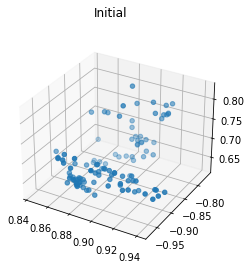

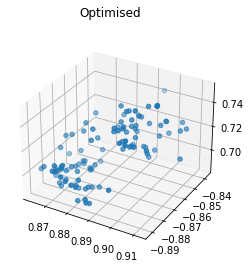

In [7]:
fig, ax = plot_positions(x0[:3], x0[3:], train=False)
fig.suptitle("Initial")
fig, ax = plot_positions(ret.x[:3], ret.x[3:], train=False)
fig.suptitle("Optimised")